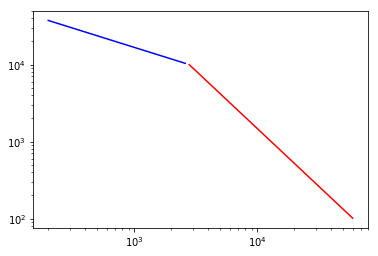

In [15]:
from scipy.integrate import quad
import numpy as np
import astropy.constants as const
AU = const.au.cgs.value
pc = const.pc.cgs.value
mh = const.m_p.cgs.value+const.m_e.cgs.value
mmw = 2.37

def inner_rho(y, x0, z0, A, Rinf):
    return A*Rinf**(0.5)*(x0**2+z0**2+y**2)**-0.25

def outer_rho(y, x0, z0, A, Rinf):
    return A*Rinf**(1.5)*(x0**2+z0**2+y**2)**-0.75

Rinf = 2800.0*AU
Rmax = 65000.0*AU
# reading from Fig. 13 before correcting the plot
a = 1e4
# convert it back to gas mass density
A = a*mh*mmw*100

x0 = 2800*AU
z0 = 200*AU

def column_density(x0, z0, A, Rinf, Rmax):
    
    b_in = (-(Rinf**2-x0**2-z0**2)**0.5, (Rinf**2-x0**2-z0**2)**0.5)
    b_out = (-(Rmax**2-x0**2-z0**2)**0.5, (Rmax**2-x0**2-z0**2)**0.5)
    if (type(b_in[1]) != complex):
        I_inner = quad(inner_rho, b_in[0], b_in[1], args=(x0, z0, A, Rinf))
        I_outer1 = quad(outer_rho, b_out[0], b_in[0], args=(x0, z0, A, Rinf))
        I_outer2 = quad(outer_rho, b_in[1], b_out[1], args=(x0, z0, A, Rinf))
    elif type(b_out[1]) == complex:
        I_inner = (np.nan,np.nan)
        I_outer1 = (np.nan,np.nan)
        I_outer2 = (np.nan,np.nan)
    else:
        I_inner = (0,0)
        I_outer1 = quad(outer_rho, b_out[0], b_out[1], args=(x0, z0, A, Rinf))
        I_outer2 = (0,0)
    
    total_I = (I_inner[0]+I_outer1[0]+I_outer2[0], (I_inner[1]**2+I_outer1[1]**2+I_outer2[1])**0.5)
    
    return total_I

# plot the radial profile at (x0, z0) = (0,0)
%matplotlib inline
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(111)

y = np.arange(200, 60000, 200)
factor = 100
ax.plot(y[y < Rinf/AU], inner_rho(y[y < Rinf/AU]*AU, 0, 0, A, Rinf)/1e2/mh/mmw, 'b-')
ax.plot(y[y >= Rinf/AU], outer_rho(y[y >= Rinf/AU]*AU, 0, 0, A, Rinf)/1e2/mh/mmw, 'r-')
ax.set_xscale('log')
ax.set_yscale('log')

In [16]:
np.log10(0.37e5*36000*365*24*3600/AU)

3.4483854197239712

In [25]:
xzrange = [200, 60000]
x = np.arange(xzrange[0], xzrange[1], 200)
z = np.arange(xzrange[0], xzrange[1], 200)
xx, zz = np.meshgrid(x,z)
N = np.empty_like(xx, dtype='float')

for i in range(len(xx)):
    for j in range(len(zz)):
        x0 = xx[i,j]*AU
        z0 = zz[i,j]*AU
        N[i,j] = column_density(float(x0), float(z0), A, Rinf, Rmax)[0]

In [26]:
# kappa at 500 um (cm2/g)
# kappa = 5.04
# kappa at 50 um (cm2/g)
kappa = 329.5

/Users/yaolun/anaconda/lib/python3.5/site-packages/matplotlib/colors.py:927: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


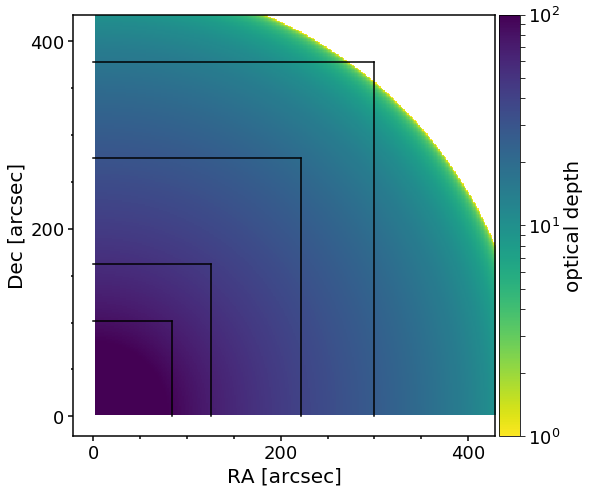

In [27]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
im = ax.imshow(N[::-1,:]*kappa, extent=[xzrange[0]/140, xzrange[1]/140, xzrange[0]/140, xzrange[1]/140],
                 norm=LogNorm(1,100), cmap=plt.cm.viridis_r)
cb = fig.colorbar(im, cax=cax)
ax.set_aspect('equal')

# HAWC+ field of view for polarization
FoV = [(1.4, 1.7), (2.1, 2.7), (3.7, 4.6), (5.0, 6.3)] # arcmin
FoV_labels = ['A', 'C', 'D', 'E']
for i, f in enumerate(FoV):
    p, = ax.plot([0,f[0]*60],[f[1]*60, f[1]*60], 'k', label=FoV_labels[i])
    ax.plot([f[0]*60, f[0]*60], [0, f[1]*60], 'k')

ax.set_xlabel('RA [arcsec]', fontsize=20)
ax.set_ylabel('Dec [arcsec]', fontsize=20)
[ax.spines[axis].set_linewidth(1.5) for axis in ['top','bottom','left','right']]
ax.minorticks_on()
ax.tick_params('both',labelsize=18,width=1.5,which='major',length=5)
ax.tick_params('both',labelsize=18,width=1.5,which='minor',length=2.5)
ax.set_xticks([0,200,400])
ax.set_yticks([0,200,400])

cb.ax.set_ylabel('optical depth', fontsize=20)
[cb.ax.spines[axis].set_linewidth(1.5) for axis in ['top','bottom','left','right']]
cb.ax.tick_params('both',labelsize=18,which='major',length=5)
cb.ax.tick_params('both',labelsize=18,which='minor',length=2.5)

# fig.savefig('/Users/yaolun/Google Drive/proposal/SOFIA/sofia_embedded_b-field/optical_depth_50um.pdf',
#             format='pdf', dpi=300, bbox_inches='tight')